# Dengue Analysis
...
---

### Understanding
- **The problem**
- **The solution**

---

### Objective
- **What to Deliver**
- **Solution Planning**
- **Dataset Overview**

---

## 0. Imports

### 0.1. Libraries

In [2]:
# Data manipulation libraries
import pandas                as pd
import numpy                 as np

# Visualization libraries
import seaborn               as sns
import matplotlib            as mpl
import matplotlib.pyplot     as plt

from matplotlib              import cm
from matplotlib.colors       import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

# import plotly.express       as px
# import plotly.graph_objects as go

# Geo libraries
import geopandas             as gpd

# Other
import warnings
import sys
import os

### 0.2. Settings

In [3]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Directory Settings
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path     = os.path.join(project_root, 'src')
sys.path.append(src_path)

# Visualization Settings
%matplotlib inline

# Set a style
mpl.style.use('ggplot')  

# Customize rcParams
mpl.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 16,
    'axes.facecolor': 'white',
    'axes.linewidth': 1,
    'axes.grid': True,
    'xtick.labelsize': 14,
    'xtick.color': 'black',
    'ytick.labelsize': 14,
    'ytick.color': 'black',
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'figure.titlesize': 24,
    'figure.figsize': (18, 9),
    'figure.dpi': 150
})

### 0.3. Functions

In [4]:
def set_plot(fig, title, xlabel, ylabel):
    """
    Summary: This function sets the plot configuration for the initial plots. 
    Args:
        fig: the figure object.
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
    Returns: figure with the image configuration.
    """
    # Customizing
    fig.set_title(title)
    fig.set_xlabel(xlabel, color='black')
    fig.set_ylabel(ylabel, color='black')
    fig.tick_params(left=False, bottom=False)

    return fig

### 0.4. Classes

In [5]:
from data_processing.data_processing import CasosDengueUF20012006, CasosDengueUF20072013, CasosDengueUF20142023
from data_processing.data_processing import ObitosDengueUF20012006, ObitosDengueUF20072013, ObitosDengueUF20142023

### 0.5. Datasets

In [6]:
# Casos de dengue em 2003 a 2006
df_casos_06 = CasosDengueUF20012006().process_data()

# Casos de dengue em 2007 a 2013
df_casos_13 = CasosDengueUF20072013().process_data()

# Casos de dengue em 2014 a 2023
df_casos_23 = CasosDengueUF20142023().process_data()

# Concatenando os dataframes
df_concat1  = pd.concat([df_casos_06, df_casos_13, df_casos_23], ignore_index=True)

# Somando casos duplicados de 2013
df_casos = df_concat1.groupby(['nome_uf', 'id_uf', 'ano']).sum().reset_index()

In [7]:
# Óbitos de dengue em 2003 a 2006
df_obitos_06 = ObitosDengueUF20012006().process_data()

# Óbitos de dengue em 2007 a 2013
df_obitos_13 = ObitosDengueUF20072013().process_data()

# Óbitos de dengue em 2014 a 2023
df_obitos_23 = ObitosDengueUF20142023().process_data()

# Concatenando os dataframes
df_concat2   = pd.concat([df_obitos_06, df_obitos_13, df_obitos_23], ignore_index=True)

# Somando casos duplicados de 2013
df_obitos = df_concat2.groupby(['nome_uf', 'id_uf', 'ano']).sum().reset_index()

In [8]:
# População
df_pop = pd.read_csv('../data/interim/uf_populacao.csv')

In [9]:
# GeoDataFrame UF Brasil
gdf = gpd.read_file('../data/interim/uf_brasil.geojson')

## 1. Data Preparation

In [10]:
# Lista com os nomes dos estados da Amazonia Legal Brasileira
nome_alb = ['Acre', 'Amapá', 'Amazonas', 'Maranhão', 'Mato Grosso', 'Pará', 'Rondônia', 'Roraima', 'Tocantins']

# Lista com os ids dos estados da Amazonia Legal Brasileira
id_alb = [12, 16, 13, 21, 51, 15, 11, 14, 17]

In [11]:
# Criando dados para 2023 como iguais aos de 2022

df_pop_2022 = df_pop[df_pop['ano'] == 2022].copy()
df_pop_2022['ano'] = 2023
df_pop = pd.concat([df_pop, df_pop_2022], ignore_index=True)

In [17]:
# Calculando taxa de incência
df_txinc = pd.merge(df_casos, df_pop, on=['nome_uf', 'id_uf', 'ano'], how='left')
df_txinc['txinc'] = df_txinc['casos'] / df_txinc['populacao'] * 100000

df_txinc = df_txinc[['nome_uf', 'id_uf', 'ano', 'casos', 'txinc']]

In [33]:
# Calculando taxa de letalidade
df_txlet = pd.merge(df_txinc, df_obitos, on=['nome_uf', 'id_uf', 'ano'], how='left')
df_txlet['obitos'] = df_txlet['obitos'].fillna(0).astype('int64')
df_txlet['txlet'] = df_txlet['obitos'] / df_txlet['casos'] * 100

df_txlet = df_txlet[['nome_uf', 'id_uf', 'ano', 'obitos', 'txlet']]

## 2. Data Exploration

In [42]:
print(df_pop.info())
df_pop

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   nome_uf    621 non-null    object
 1   id_uf      621 non-null    int64 
 2   ano        621 non-null    int64 
 3   populacao  621 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.5+ KB
None


,nome_uf,id_uf,ano,populacao
0,Acre,12,2001,574355
1,Acre,12,2002,586942
2,Acre,12,2003,600595
3,Acre,12,2004,630328
4,Acre,12,2005,669736
...,...,...,...,...
616,Roraima,14,2023,636707
617,Santa Catarina,42,2023,7610361
618,Sergipe,28,2023,2210004
619,São Paulo,35,2023,44411238


In [41]:
print(df_casos.info())
df_casos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nome_uf  567 non-null    object
 1   id_uf    567 non-null    int64 
 2   ano      567 non-null    int64 
 3   casos    567 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 17.8+ KB
None


,nome_uf,id_uf,ano,casos
0,Acre,12,2003,970
1,Acre,12,2004,4679
2,Acre,12,2005,2280
3,Acre,12,2006,265
4,Acre,12,2007,521
...,...,...,...,...
562,Tocantins,17,2019,13727
563,Tocantins,17,2020,1916
564,Tocantins,17,2021,9523
565,Tocantins,17,2022,20757


In [21]:
print(df_obitos.info())
df_obitos

,nome_uf,id_uf,ano,obitos
0,Acre,12,2003,0
1,Acre,12,2004,2
2,Acre,12,2005,0
3,Acre,12,2006,1
4,Acre,12,2007,0
...,...,...,...,...
547,Tocantins,17,2019,10
548,Tocantins,17,2020,0
549,Tocantins,17,2021,6
550,Tocantins,17,2022,8


In [40]:
print(df_txinc.info())
df_txinc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567 entries, 0 to 566
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nome_uf  567 non-null    object 
 1   id_uf    567 non-null    int64  
 2   ano      567 non-null    int64  
 3   casos    567 non-null    int64  
 4   txinc    567 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 26.6+ KB
None


,nome_uf,id_uf,ano,casos,txinc
0,Acre,12,2003,970,161.51
1,Acre,12,2004,4679,742.31
2,Acre,12,2005,2280,340.43
3,Acre,12,2006,265,38.59
4,Acre,12,2007,521,76.24
...,...,...,...,...,...
562,Tocantins,17,2019,13727,872.74
563,Tocantins,17,2020,1916,120.48
564,Tocantins,17,2021,9523,592.46
565,Tocantins,17,2022,20757,1373.31


In [35]:
print(df_txlet.info())
df_txlet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567 entries, 0 to 566
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nome_uf  567 non-null    object 
 1   id_uf    567 non-null    int64  
 2   ano      567 non-null    int64  
 3   obitos   567 non-null    int64  
 4   txlet    567 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 26.6+ KB
None


,nome_uf,id_uf,ano,obitos,txlet
0,Acre,12,2003,0,0.00
1,Acre,12,2004,2,0.04
2,Acre,12,2005,0,0.00
3,Acre,12,2006,1,0.38
4,Acre,12,2007,0,0.00
...,...,...,...,...,...
562,Tocantins,17,2019,10,0.07
563,Tocantins,17,2020,0,0.00
564,Tocantins,17,2021,6,0.06
565,Tocantins,17,2022,8,0.04


## 3. Data Statistics

### 3.1. Casos de Dengue por UF no Brasil e na Amazônia Legal Brasileira nos últimos 10 anos 

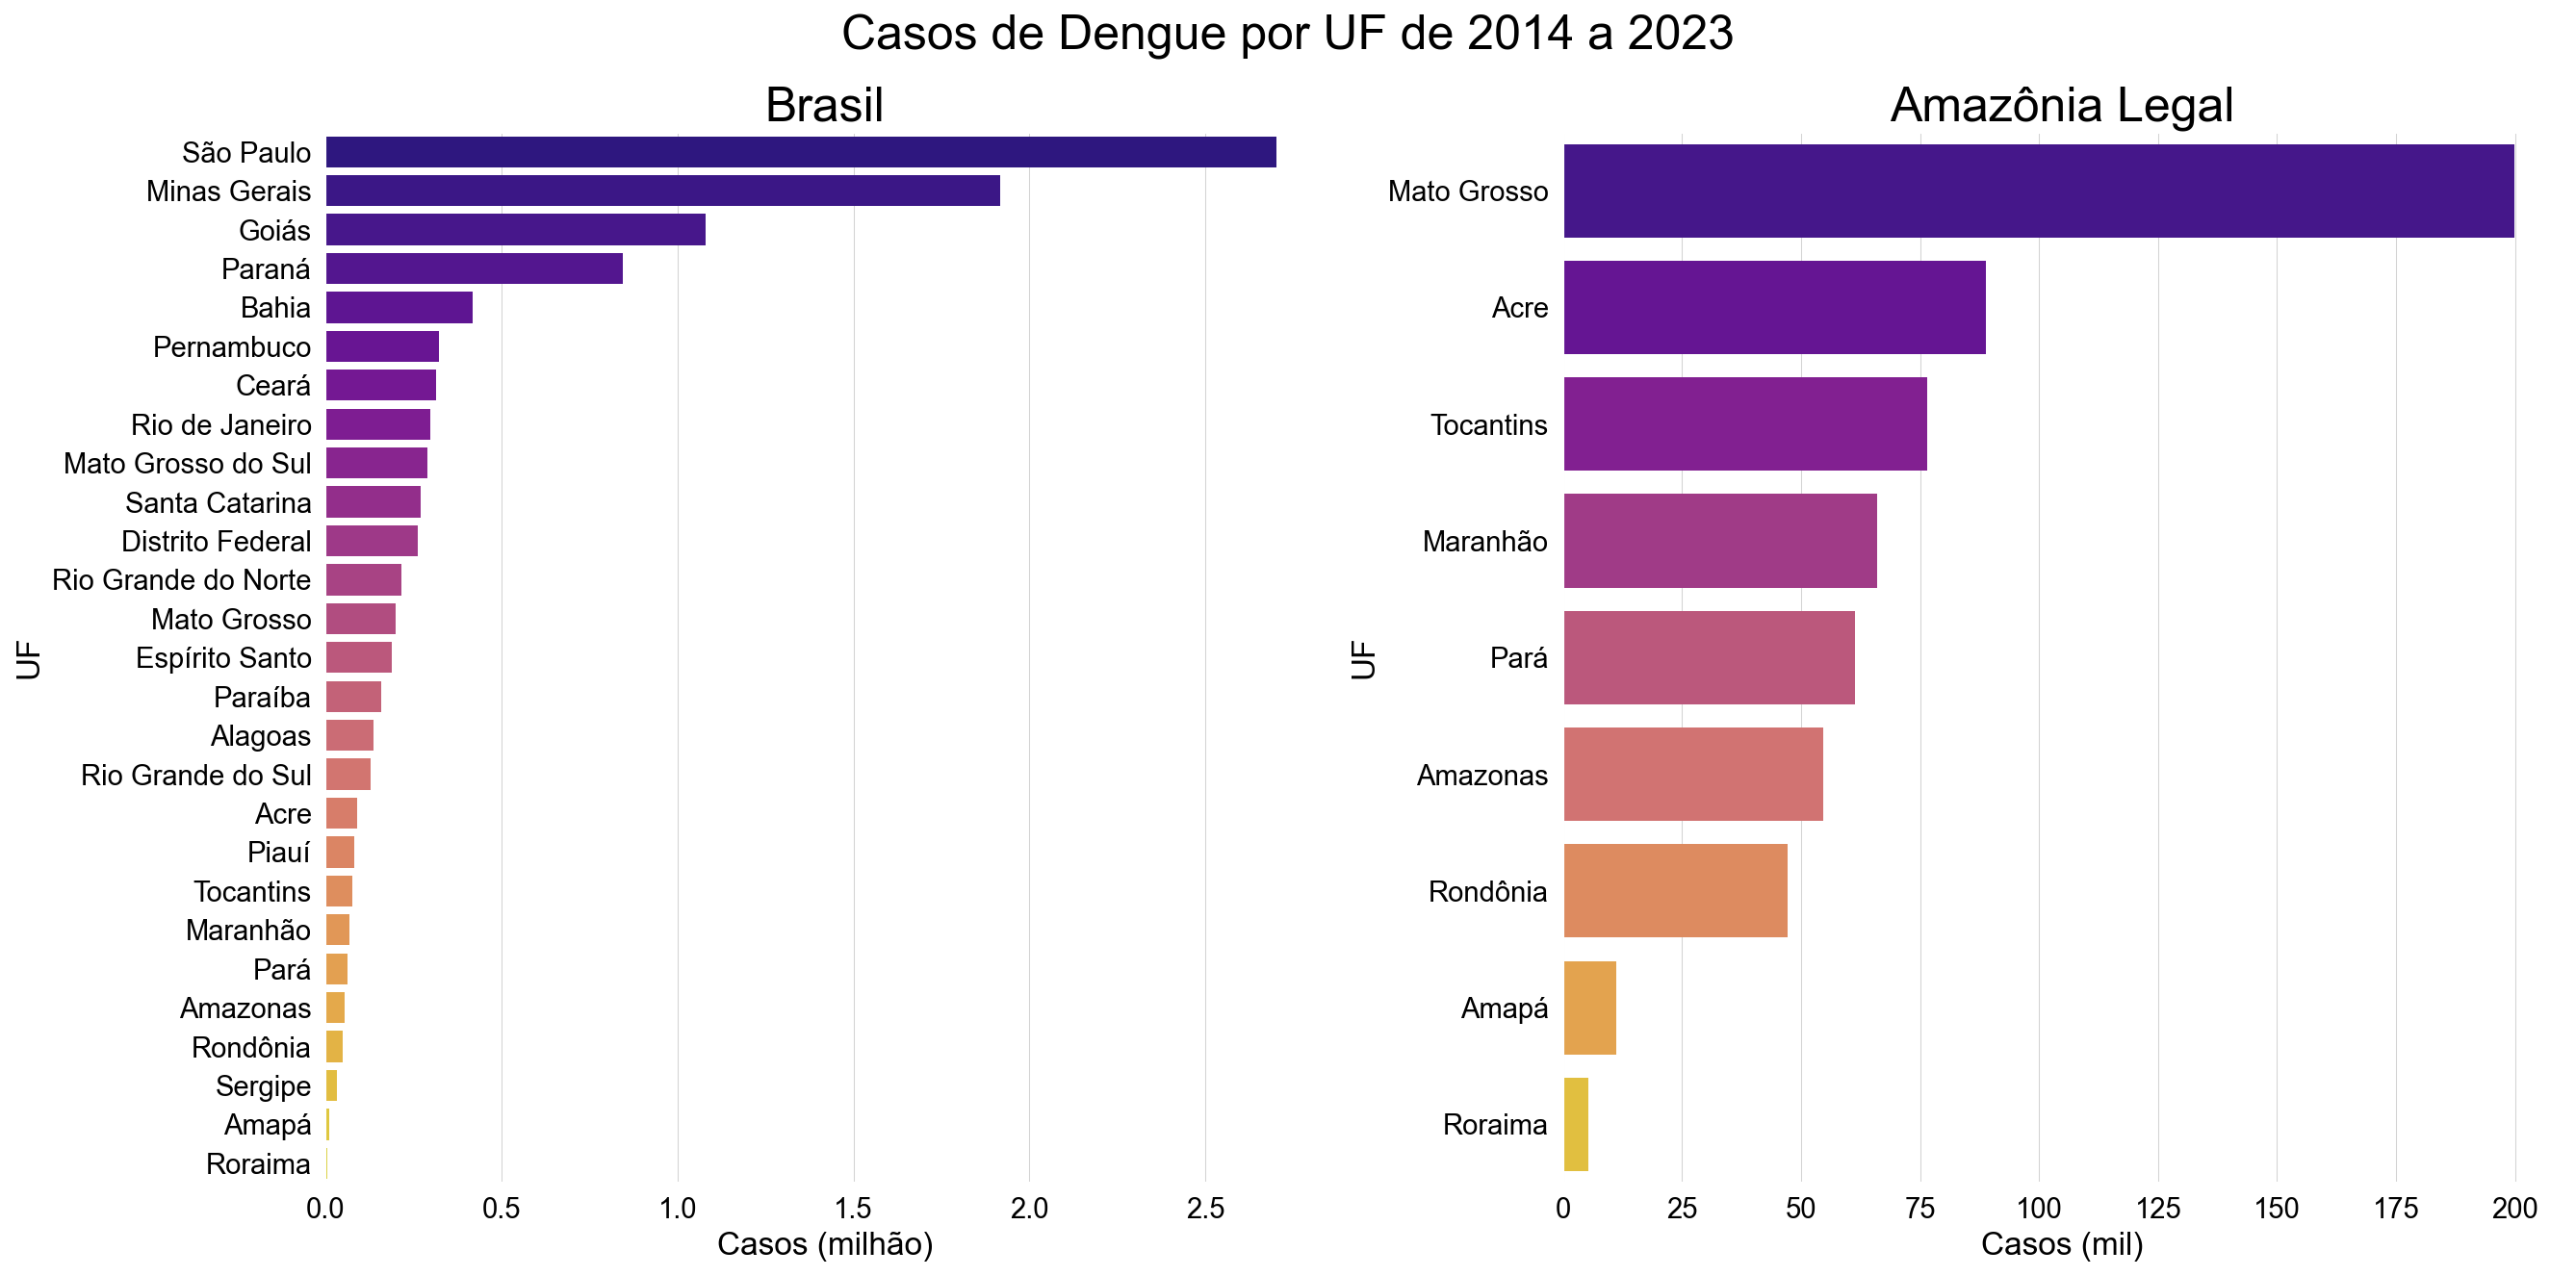

In [36]:
# Data manipulation
aux1 = df_casos[df_casos['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='casos', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

aux1['casos'] = aux1['casos'] / 1000000
aux2['casos'] = aux2['casos'] / 1000

# Figure
fig, axes = plt.subplots(1, 2)

ax1 = sns.barplot(data=aux1, x='casos', y='nome_uf', palette='plasma', ax=axes[0])
ax1 = set_plot(ax1, 'Brasil', 'Casos (milhão)', 'UF')

ax2 = sns.barplot(data=aux2, x='casos', y='nome_uf', palette='plasma', ax=axes[1])
ax2 = set_plot(ax2, 'Amazônia Legal', 'Casos (mil)', 'UF')

plt.suptitle('Casos de Dengue por UF de 2014 a 2023')
plt.tight_layout()

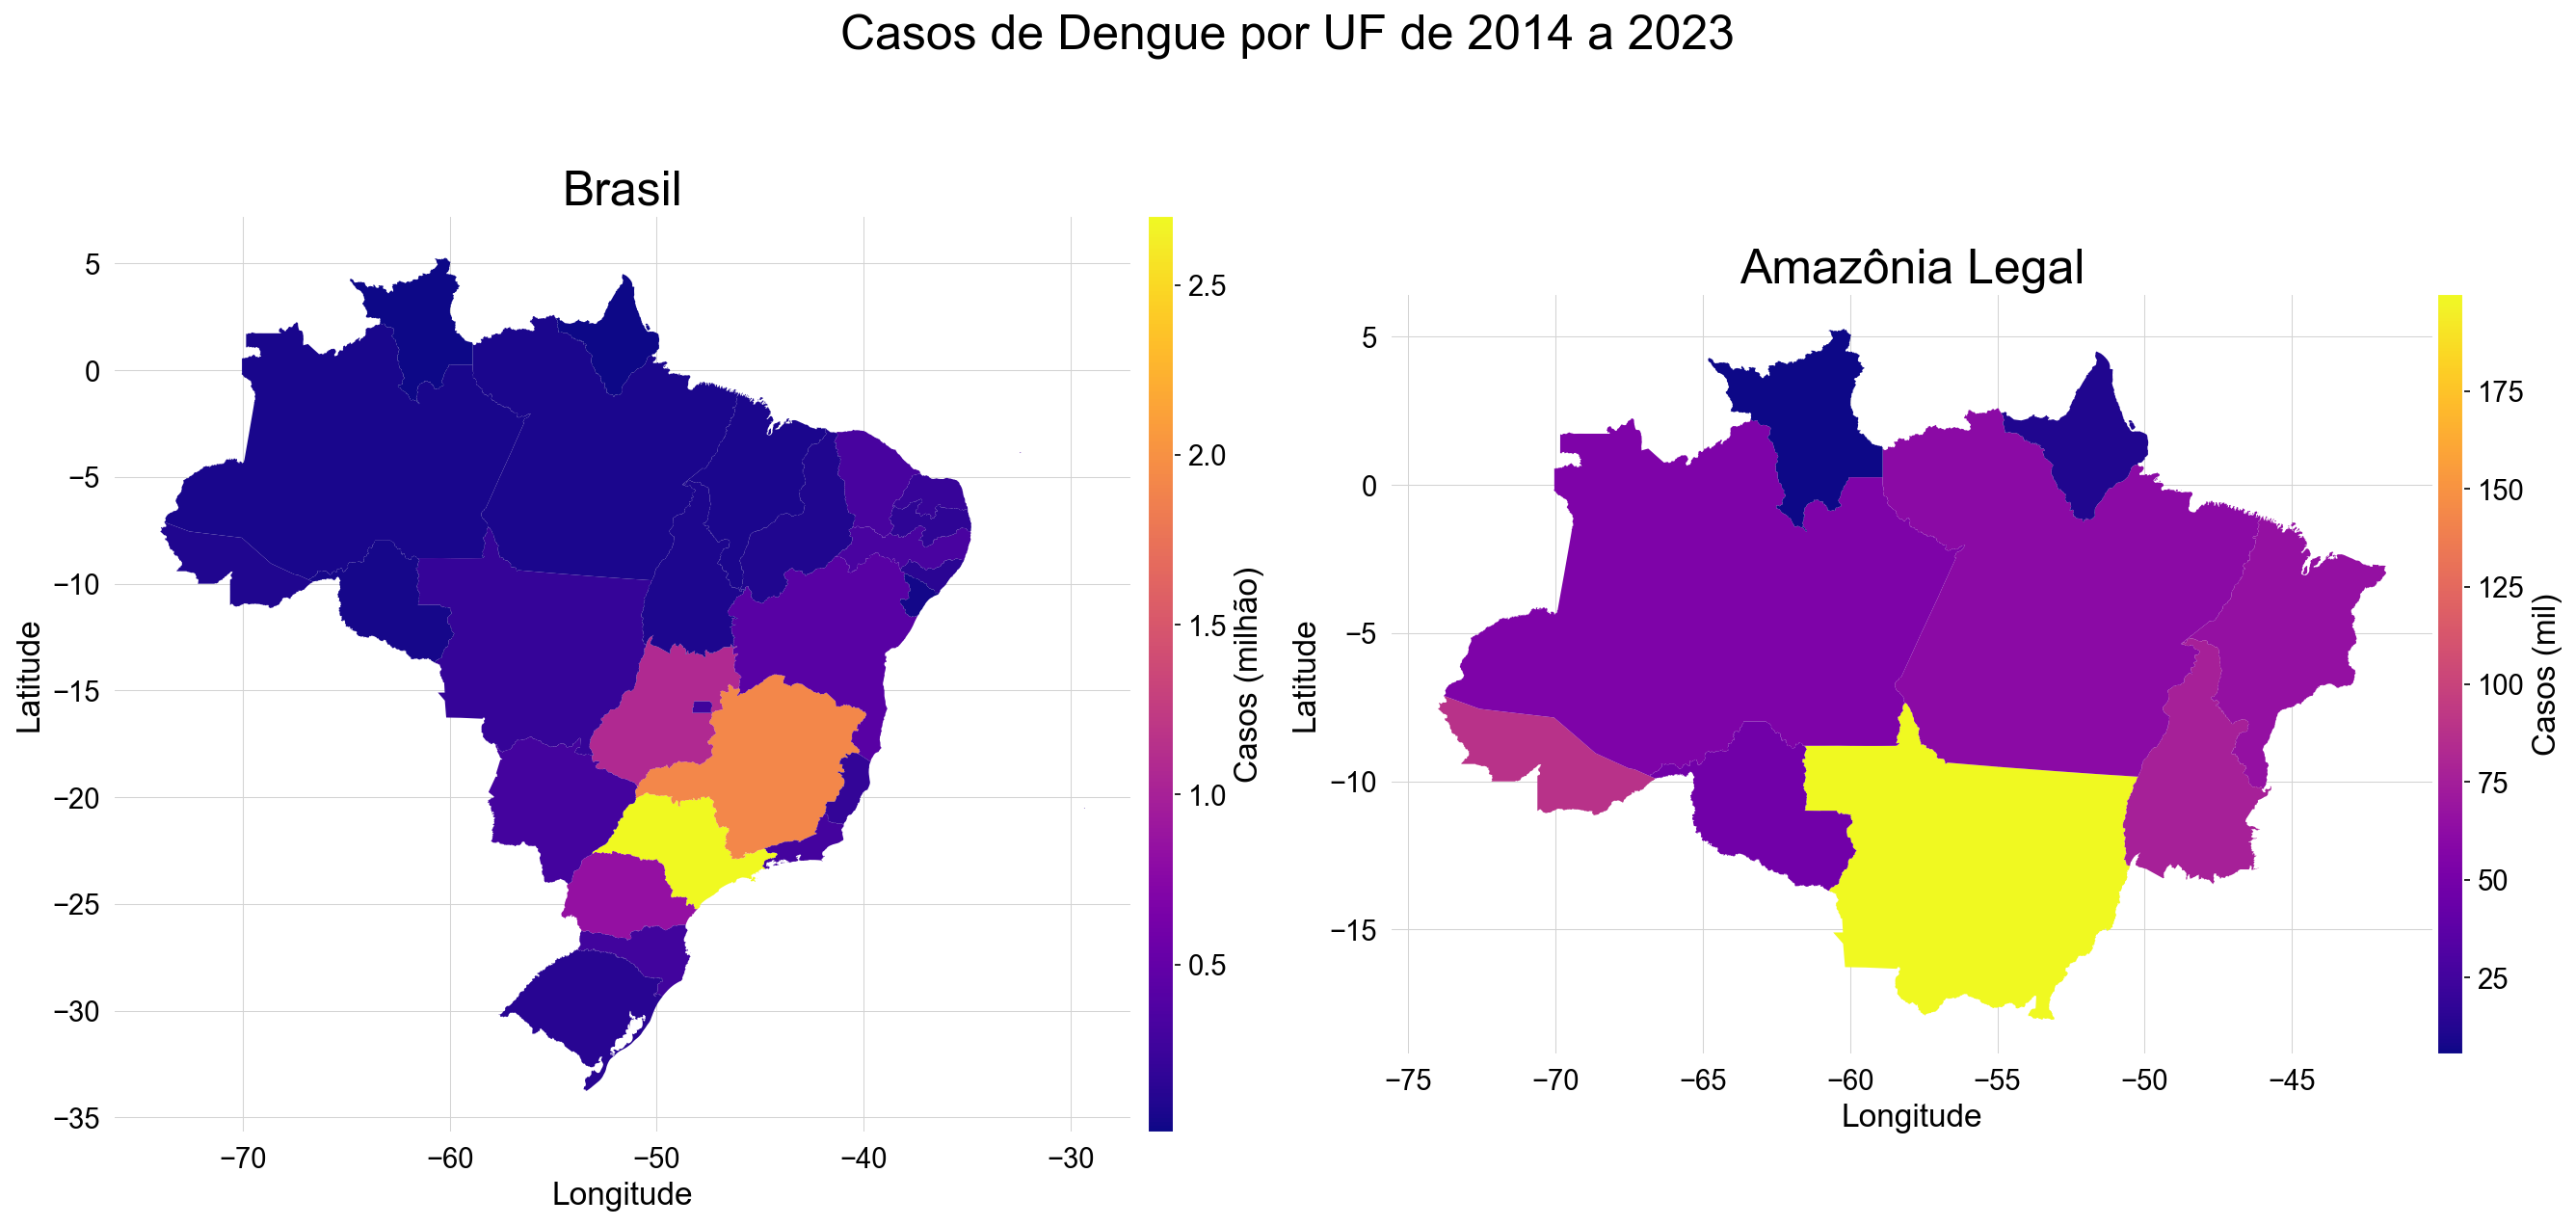

In [38]:
# Data manipulation
aux1 = df_casos[df_casos['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='casos', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

aux1['casos'] = aux1['casos'] / 1000000
aux2['casos'] = aux2['casos'] / 1000

aux1 = aux1.merge(gdf, on='id_uf')
aux2 = aux2.merge(gdf, on='id_uf')

aux1 = gpd.GeoDataFrame(aux1[['nome_uf', 'id_uf', 'casos', 'geometry']], geometry=aux1.geometry)
aux2 = gpd.GeoDataFrame(aux2[['nome_uf', 'id_uf', 'casos', 'geometry']], geometry=aux2.geometry)

# Figure
fig, axes = plt.subplots(1, 2)

# Plot 1
ax1 = aux1.plot(ax=axes[0], column='casos', cmap='plasma', legend=False)

# Customize 1
ax1 = set_plot(ax1, 'Brasil', 'Longitude', 'Latitude')

# Legend 1
div   = make_axes_locatable(axes[0])
cax1  = div.append_axes('right', size='2.5%', pad=0)
cbar1 = fig.colorbar(axes[0].collections[0], cax=cax1)
cbar1 = cbar1.set_label('Casos (milhão)', color='black')

# Plot 2
ax2 = aux2.plot(ax=axes[1], column='casos', cmap='plasma', legend=False)

# Customize 2
ax2 = set_plot(ax2, 'Amazônia Legal', 'Longitude', 'Latitude')

# Legend 2
div   = make_axes_locatable(axes[1])
cax2  = div.append_axes('right', size='2.5%', pad=0)
cbar2 = fig.colorbar(axes[1].collections[0], cax=cax2)
cbar2 = cbar2.set_label('Casos (mil)', color='black')

# Figure update
plt.suptitle('Casos de Dengue por UF de 2014 a 2023')
plt.tight_layout()

### 3.2. Estados com mais e menos óbitos por agravamento de dengue nos últimos 10 anos

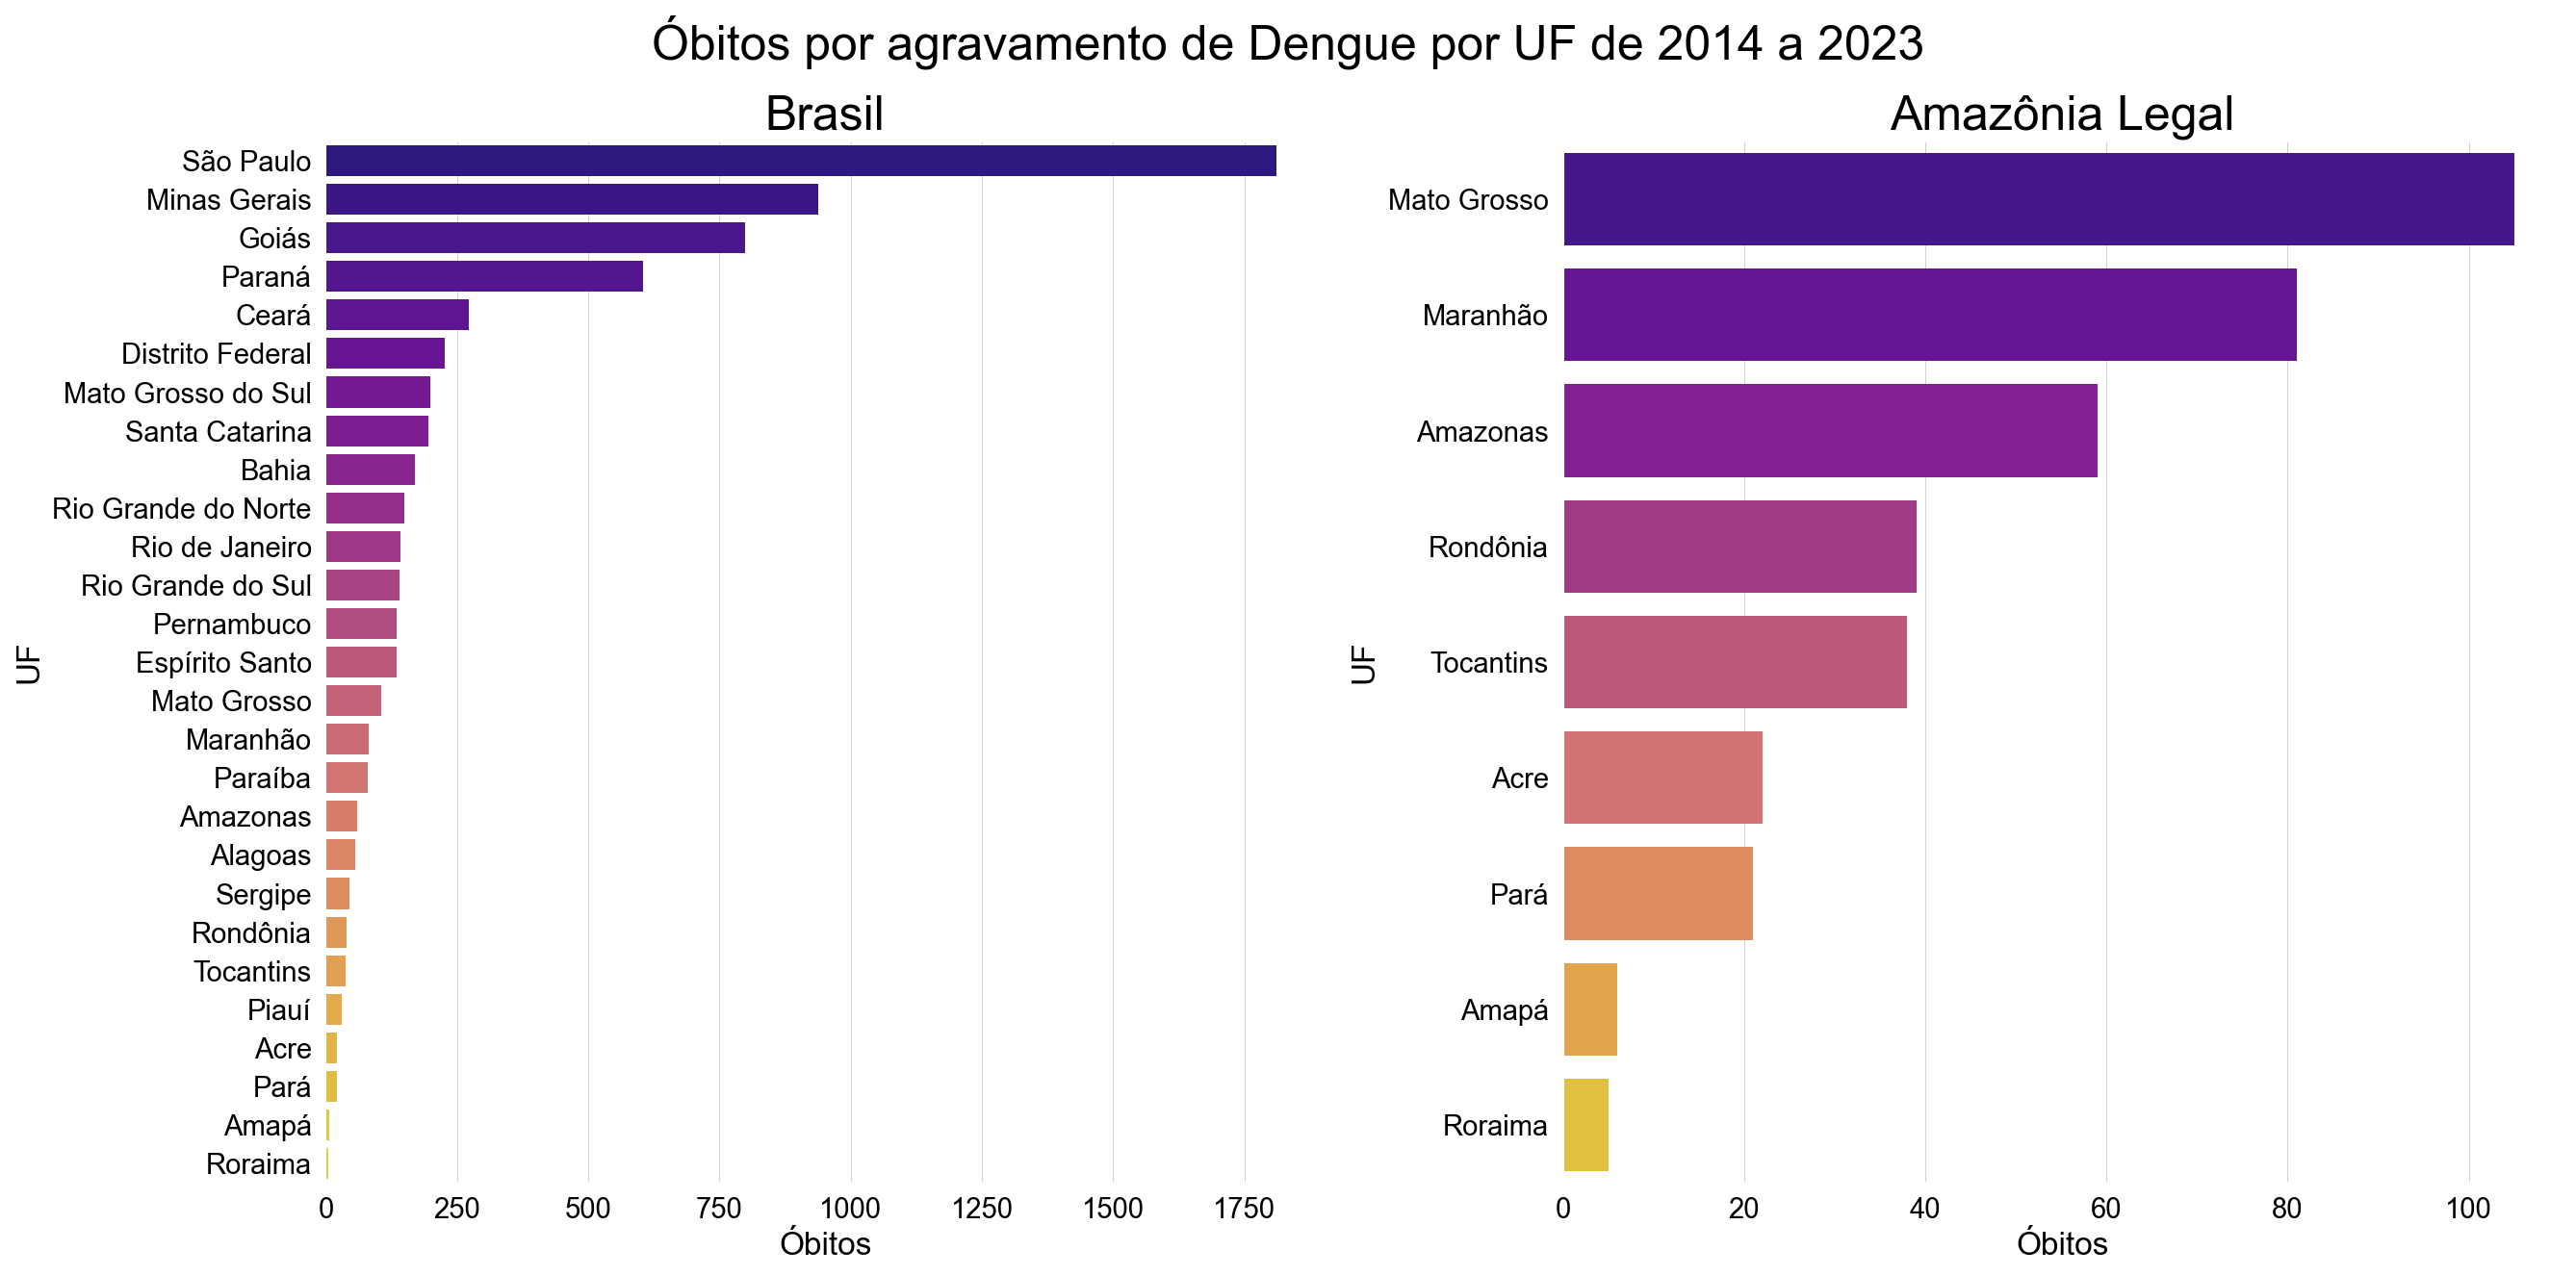

In [39]:
# Data manipulation
aux1 = df_obitos[df_obitos['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='obitos', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

# Figure
fig, axes = plt.subplots(1, 2)

ax1 = sns.barplot(data=aux1, x='obitos', y='nome_uf', palette='plasma', ax=axes[0])
ax1 = set_plot(ax1, 'Brasil', 'Óbitos', 'UF')

ax2 = sns.barplot(data=aux2, x='obitos', y='nome_uf', palette='plasma', ax=axes[1])
ax2 = set_plot(ax2, 'Amazônia Legal', 'Óbitos', 'UF')

plt.suptitle('Óbitos por agravamento de Dengue por UF de 2014 a 2023')
plt.tight_layout()

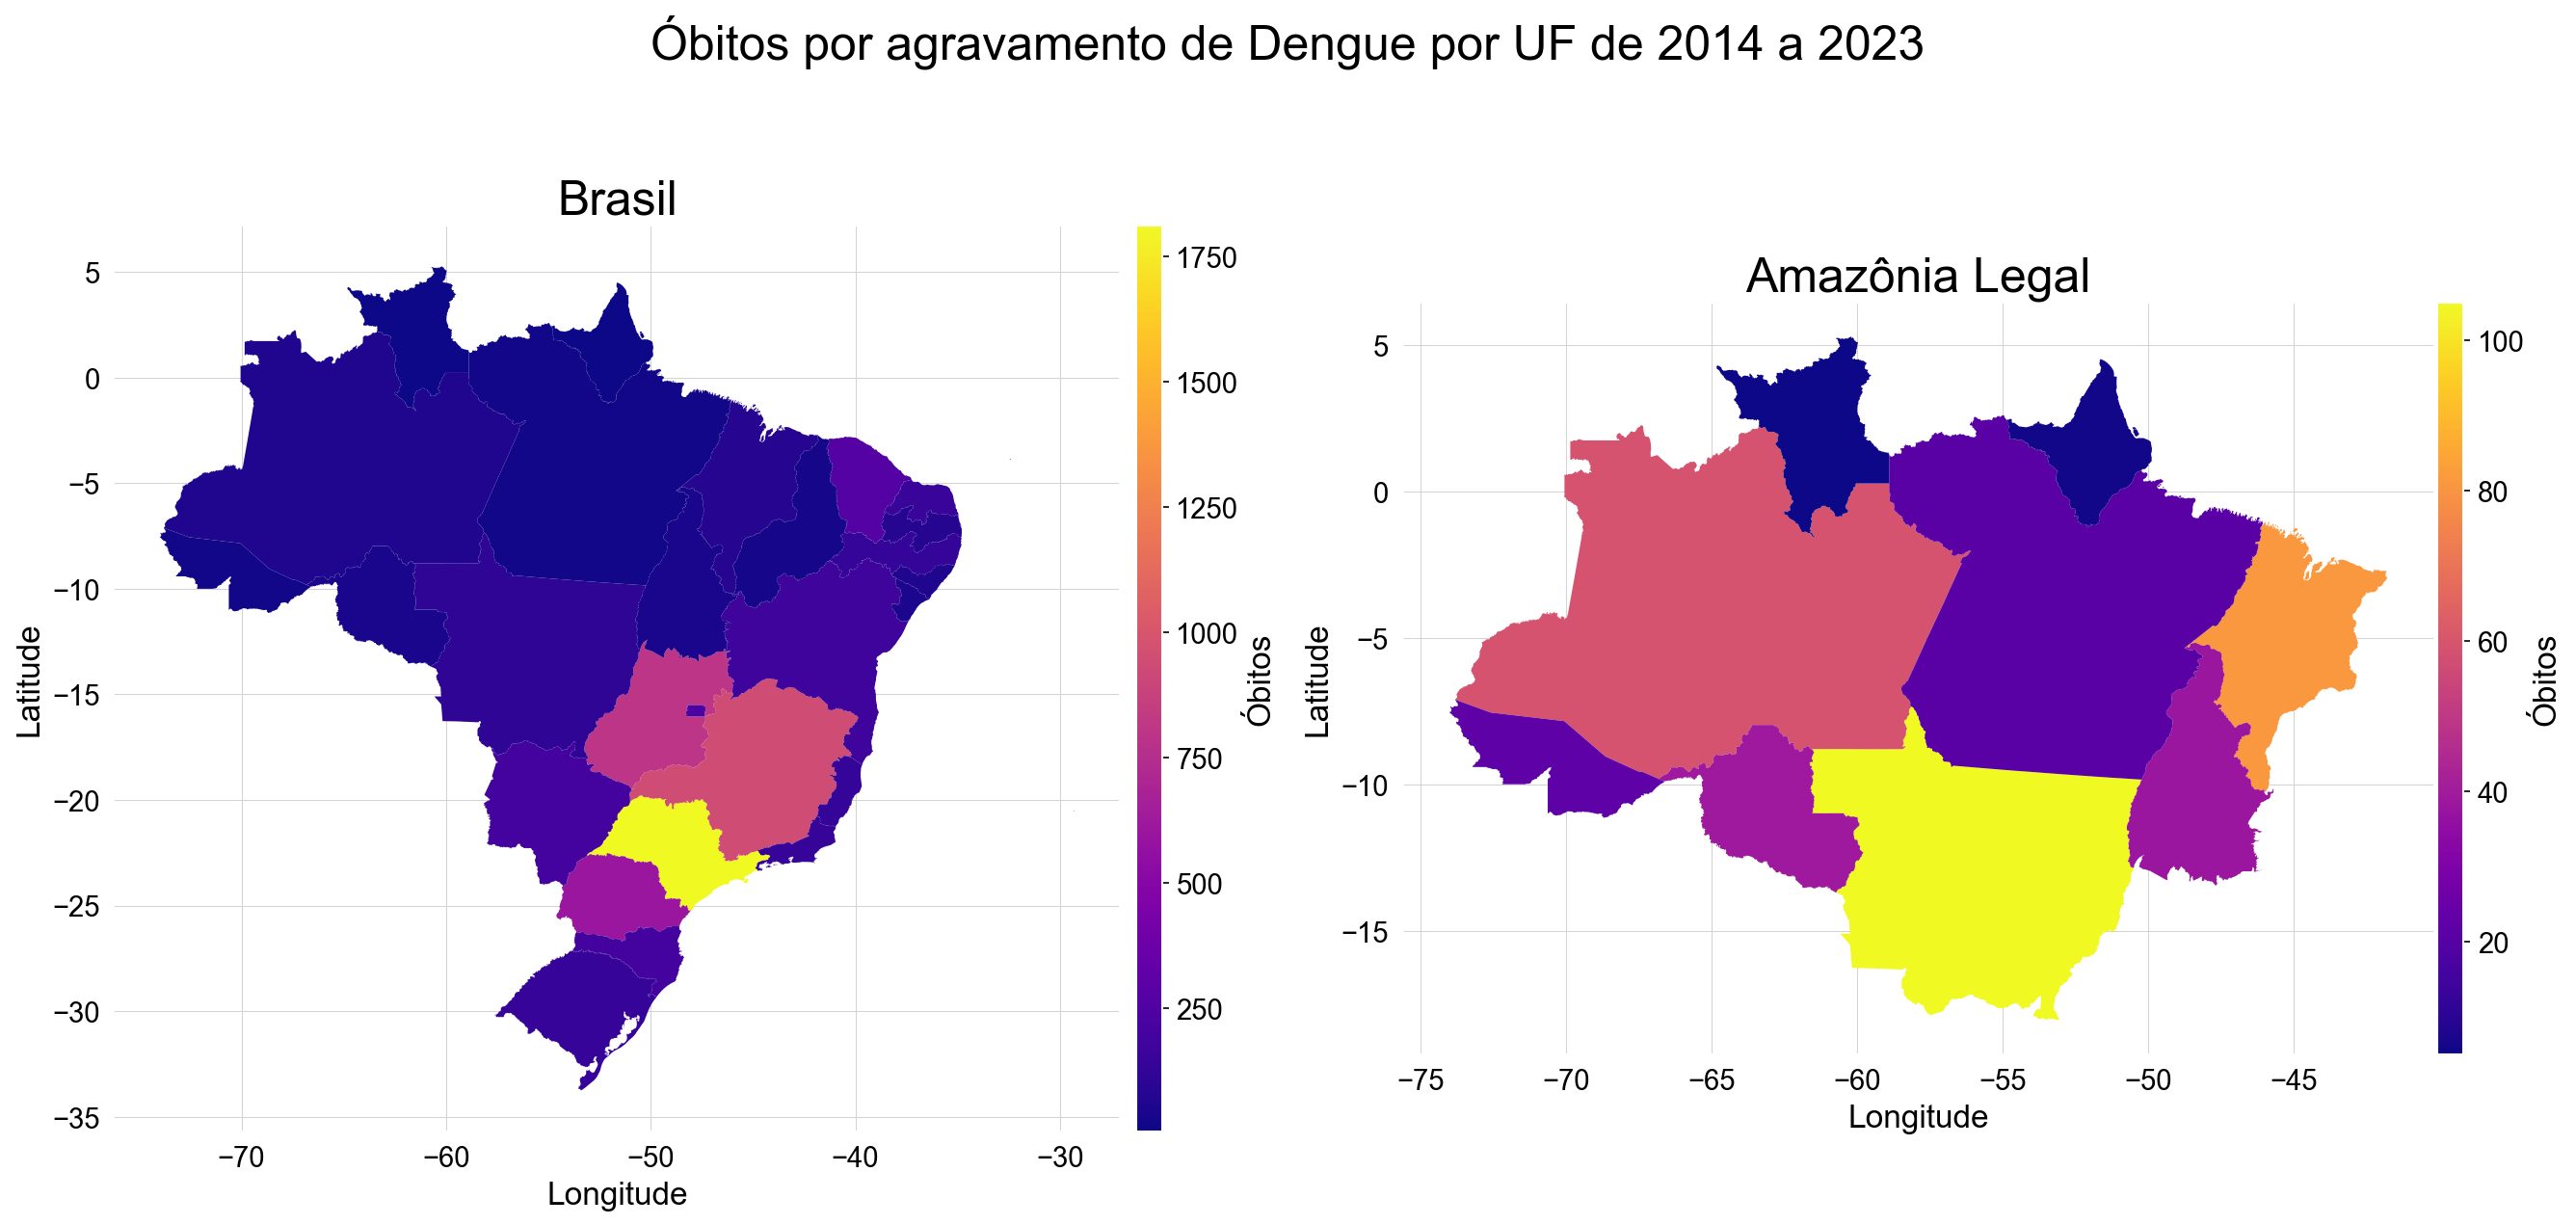

In [67]:
# Data manipulation
aux1 = df_obitos[df_obitos['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='obitos', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

aux1 = aux1.merge(gdf, on='id_uf')
aux2 = aux2.merge(gdf, on='id_uf')

aux1 = gpd.GeoDataFrame(aux1[['nome_uf', 'id_uf', 'obitos', 'geometry']], geometry=aux1.geometry)
aux2 = gpd.GeoDataFrame(aux2[['nome_uf', 'id_uf', 'obitos', 'geometry']], geometry=aux2.geometry)

# Figure
fig, axes = plt.subplots(1, 2)

# Plot 1
ax1 = aux1.plot(ax=axes[0], column='obitos', cmap='plasma', legend=False)

# Customize 1
ax1 = set_plot(ax1, 'Brasil', 'Longitude', 'Latitude')

# Legend 1
div   = make_axes_locatable(axes[0])
cax1  = div.append_axes('right', size='2.5%', pad=0)
cbar1 = fig.colorbar(axes[0].collections[0], cax=cax1)
cbar1 = cbar1.set_label('Óbitos', color='black')

# Plot 2
ax2 = aux2.plot(ax=axes[1], column='obitos', cmap='plasma', legend=False)

# Customize 2
ax2 = set_plot(ax2, 'Amazônia Legal', 'Longitude', 'Latitude')

# Legend 2
div   = make_axes_locatable(axes[1])
cax2  = div.append_axes('right', size='2.5%', pad=0)
cbar2 = fig.colorbar(axes[1].collections[0], cax=cax2)
cbar2 = cbar2.set_label('Óbitos', color='black')

# Figure update
plt.suptitle('Óbitos por agravamento de Dengue por UF de 2014 a 2023')
plt.tight_layout()

### 3.3. Taxa de Incidência (x100.000 hab.) de dengue nos estados brasileiros

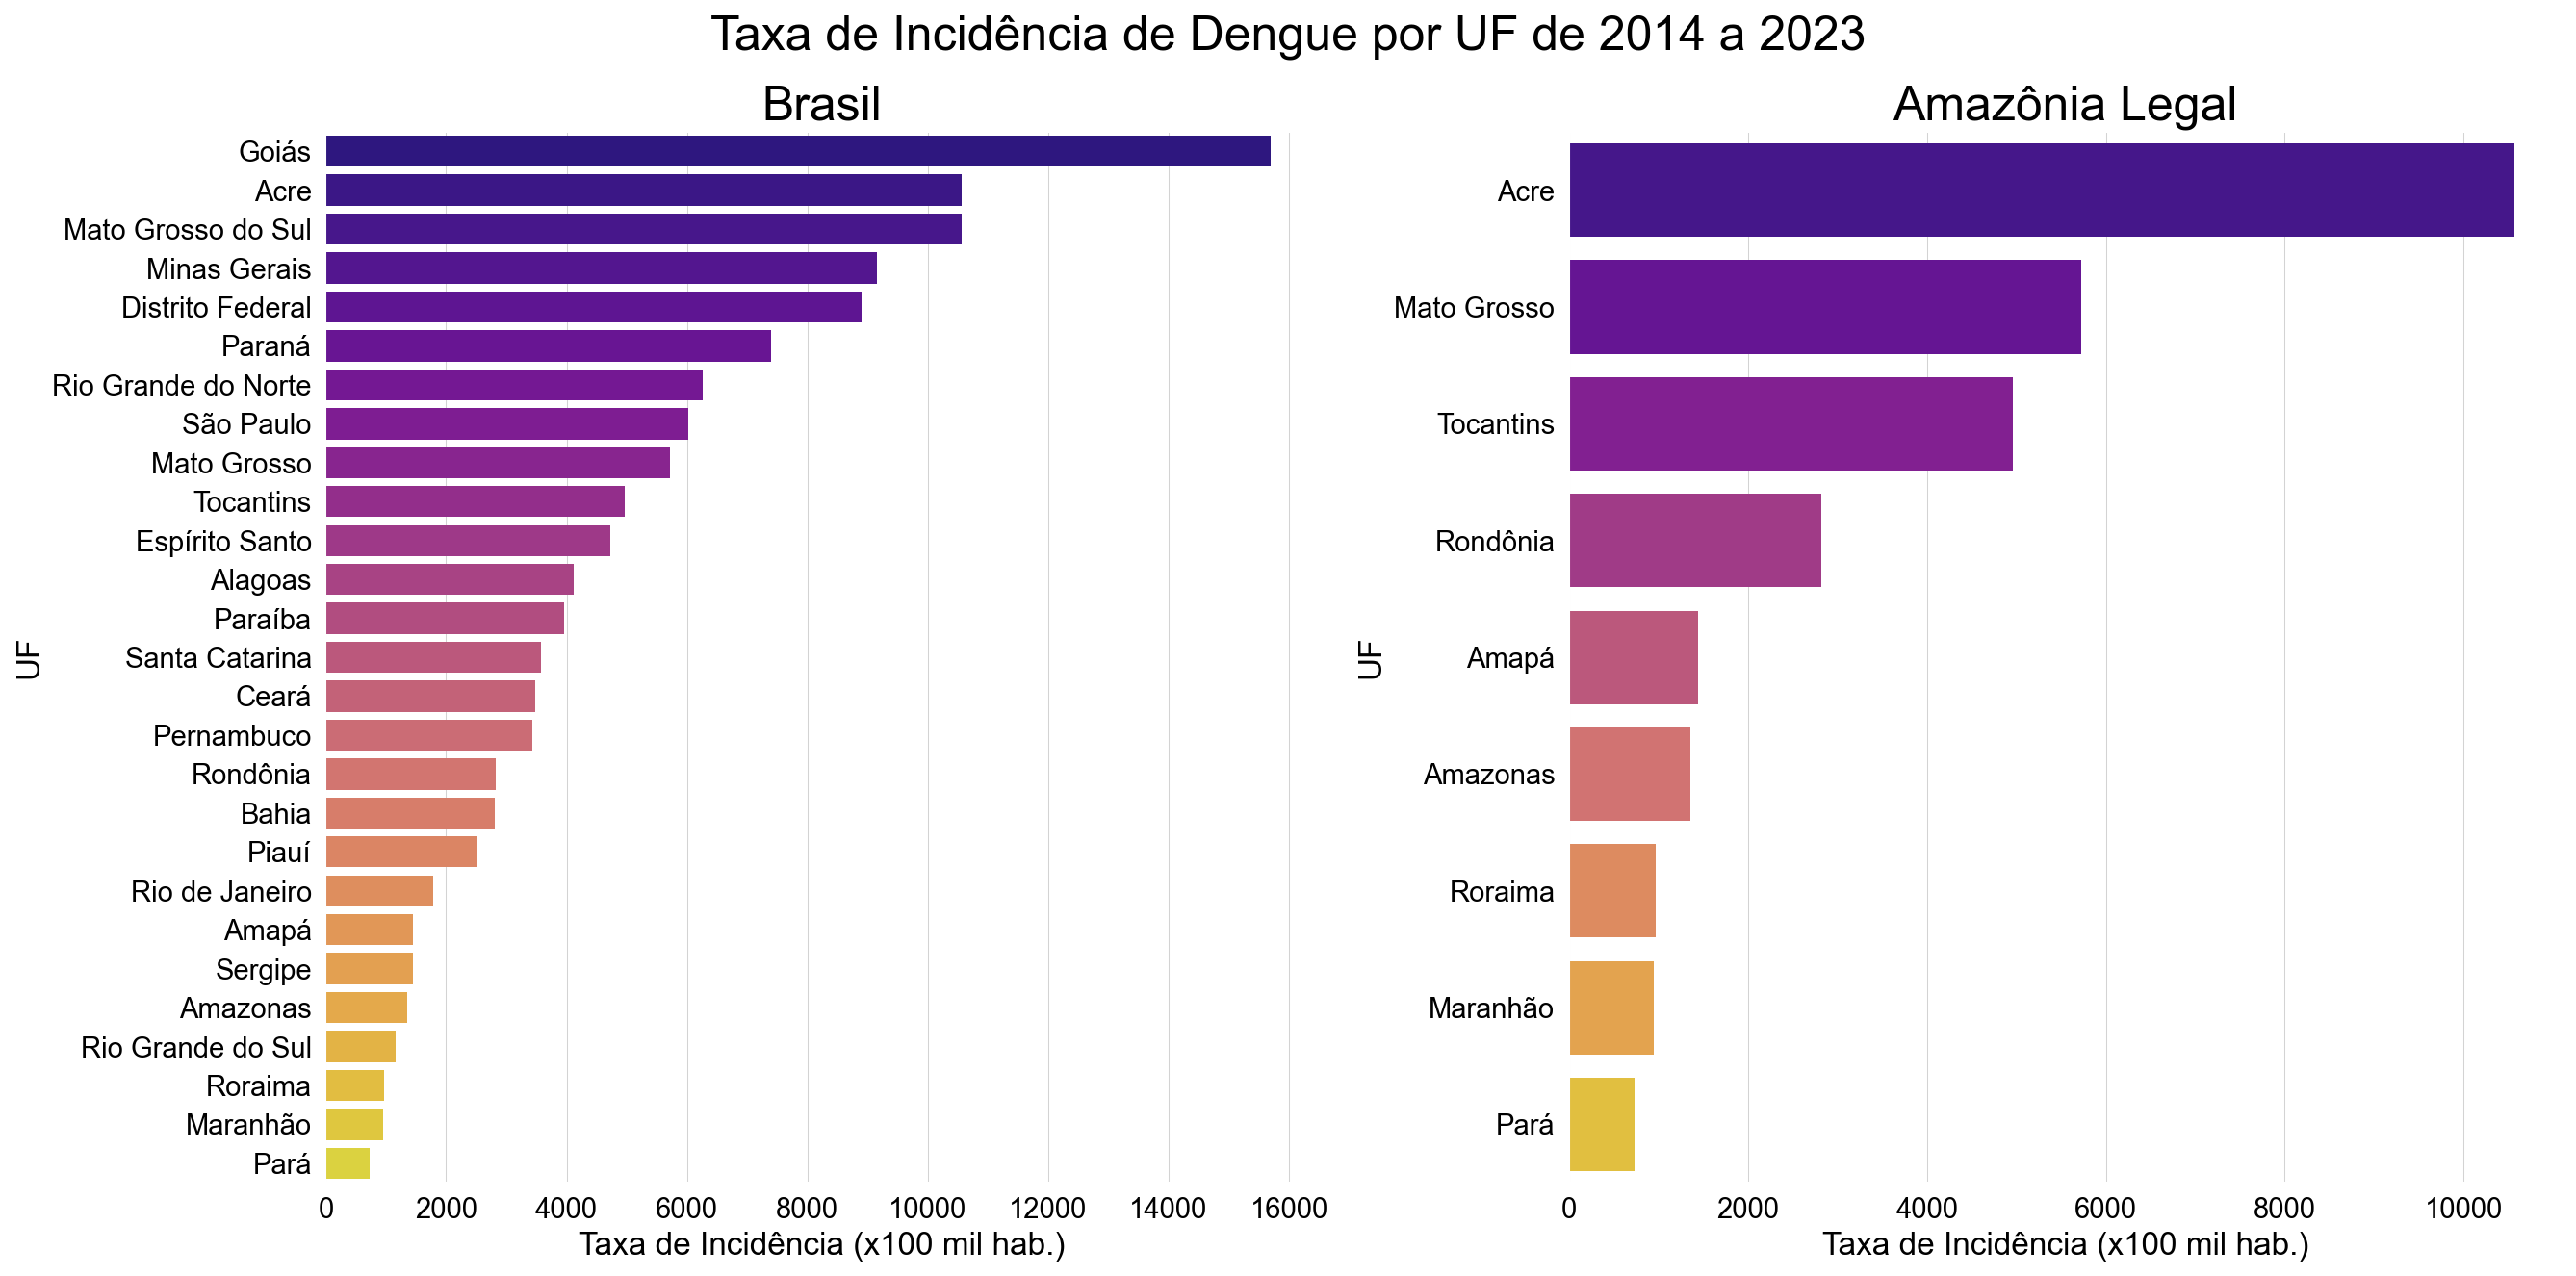

In [46]:
# Data manipulation
aux1 = df_txinc[df_txinc['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='txinc', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

# Figure
fig, axes = plt.subplots(1, 2)

ax1 = sns.barplot(data=aux1, x='txinc', y='nome_uf', palette='plasma', ax=axes[0])
ax1 = set_plot(ax1, 'Brasil', 'Taxa de Incidência (x100 mil hab.)', 'UF')

ax2 = sns.barplot(data=aux2, x='txinc', y='nome_uf', palette='plasma', ax=axes[1])
ax2 = set_plot(ax2, 'Amazônia Legal', 'Taxa de Incidência (x100 mil hab.)', 'UF')

plt.suptitle('Taxa de Incidência de Dengue por UF de 2014 a 2023')
plt.tight_layout()

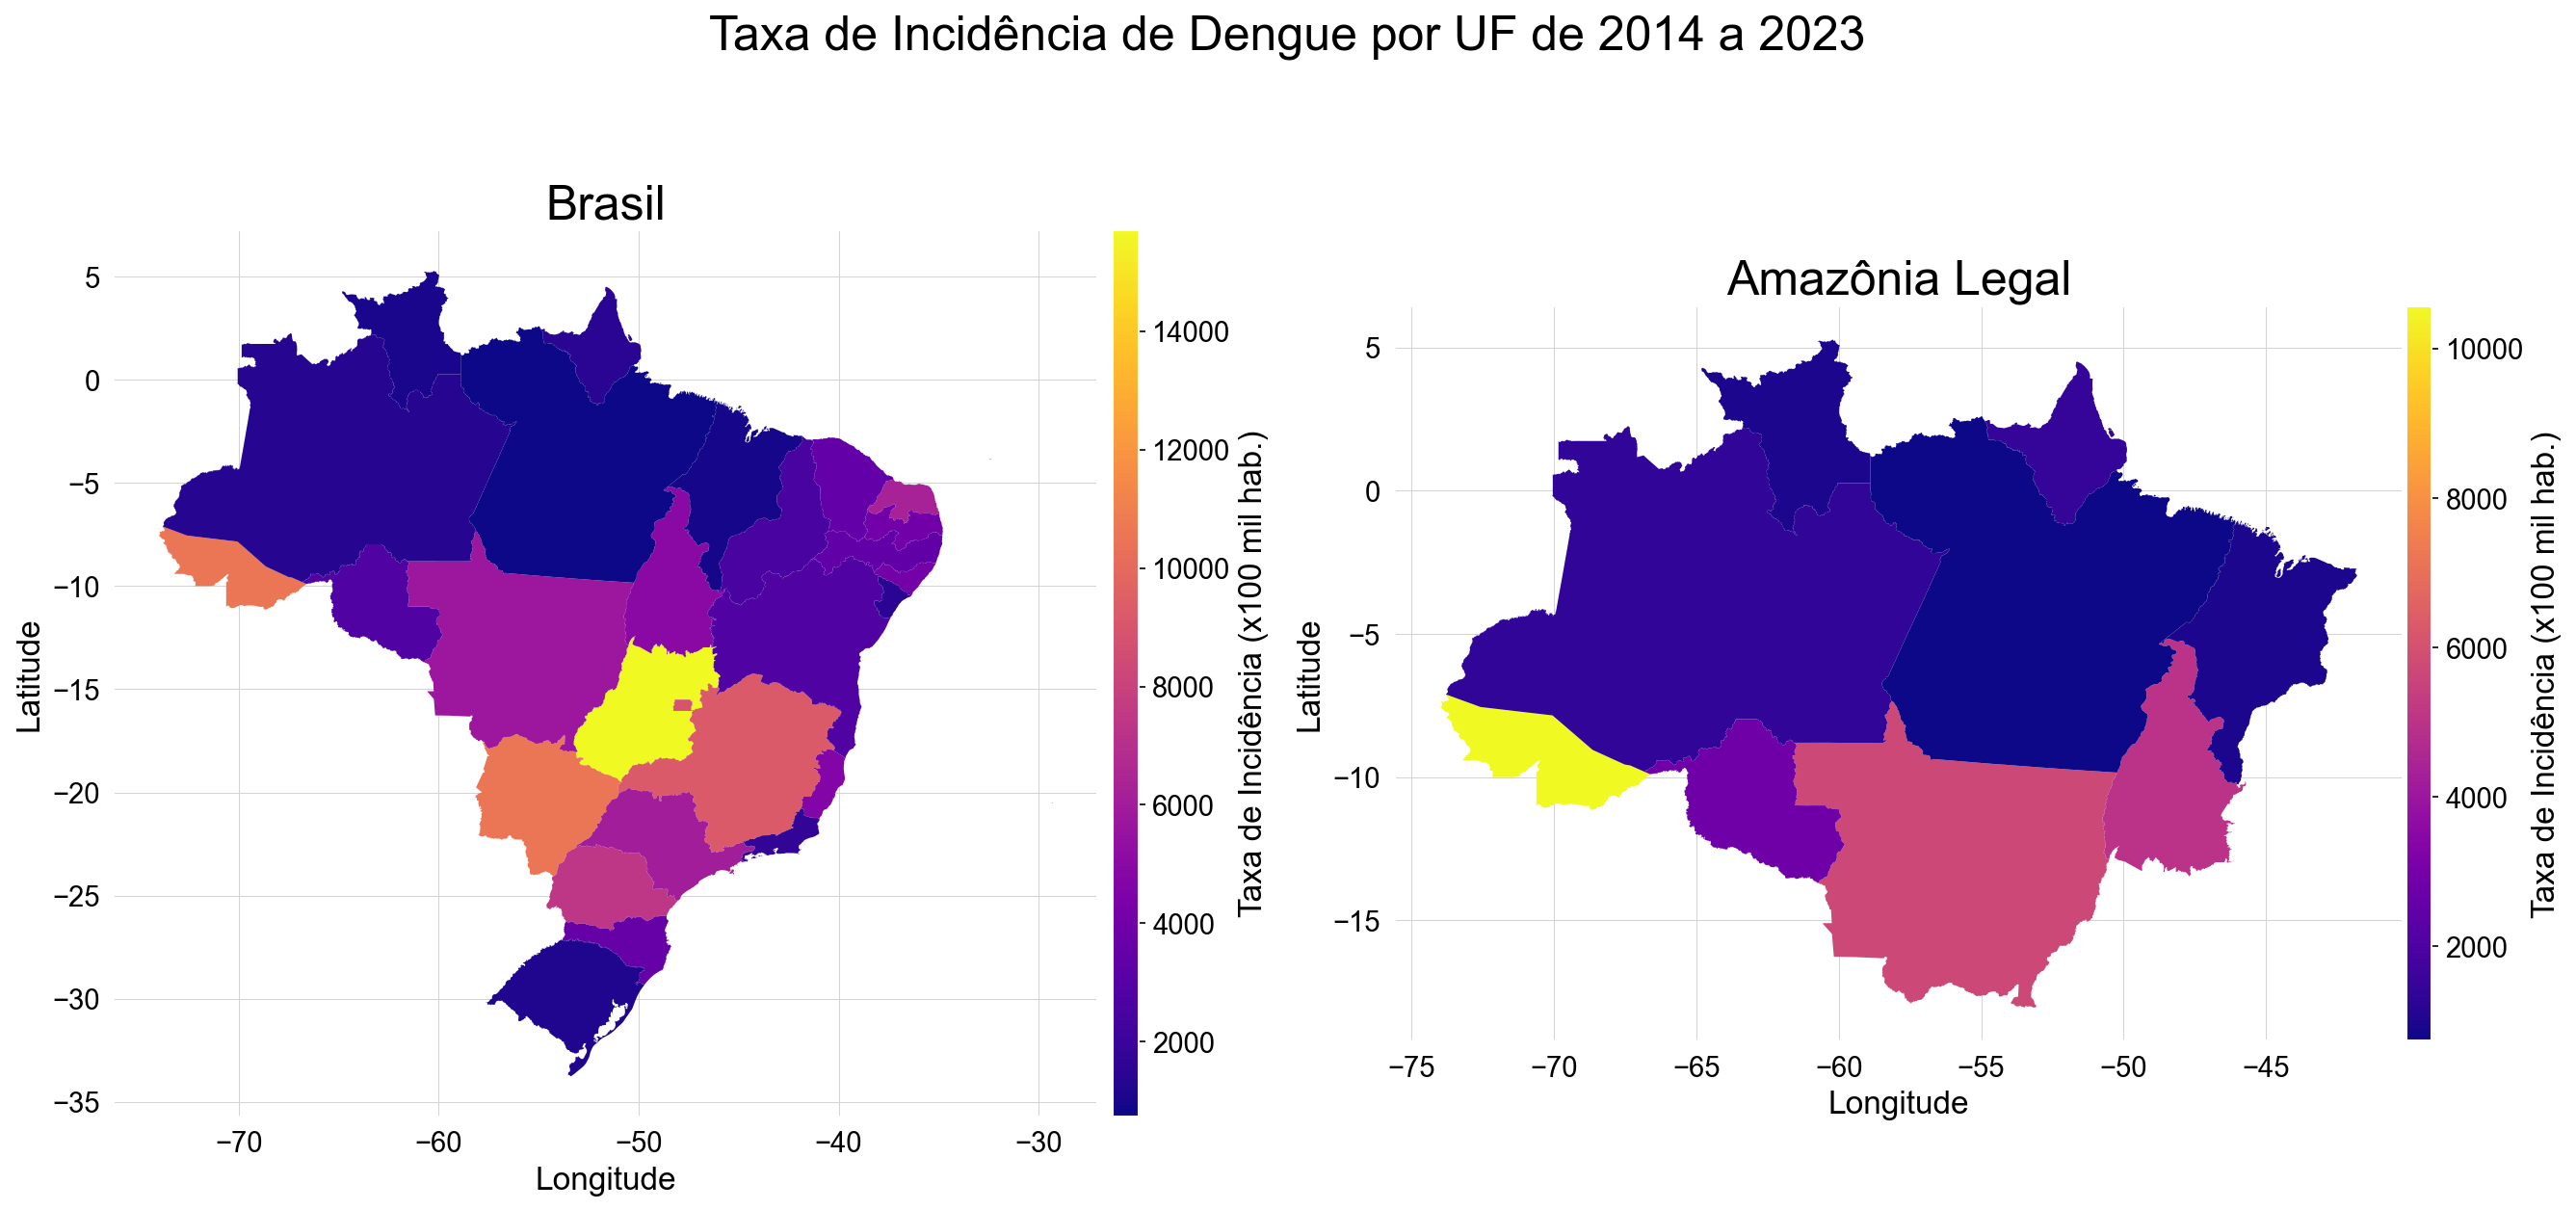

In [48]:
# Data manipulation
aux1 = df_txinc[df_txinc['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='txinc', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

aux1 = aux1.merge(gdf, on='id_uf')
aux2 = aux2.merge(gdf, on='id_uf')

aux1 = gpd.GeoDataFrame(aux1[['nome_uf', 'id_uf', 'txinc', 'geometry']], geometry=aux1.geometry)
aux2 = gpd.GeoDataFrame(aux2[['nome_uf', 'id_uf', 'txinc', 'geometry']], geometry=aux2.geometry)

# Figure
fig, axes = plt.subplots(1, 2)

# Plot 1
ax1 = aux1.plot(ax=axes[0], column='txinc', cmap='plasma', legend=False)

# Customize 1
ax1 = set_plot(ax1, 'Brasil', 'Longitude', 'Latitude')

# Legend 1
div   = make_axes_locatable(axes[0])
cax1  = div.append_axes('right', size='2.5%', pad=0)
cbar1 = fig.colorbar(axes[0].collections[0], cax=cax1)
cbar1 = cbar1.set_label('Taxa de Incidência (x100 mil hab.)', color='black')

# Plot 2
ax2 = aux2.plot(ax=axes[1], column='txinc', cmap='plasma', legend=False)

# Customize 2
ax2 = set_plot(ax2, 'Amazônia Legal', 'Longitude', 'Latitude')

# Legend 2
div   = make_axes_locatable(axes[1])
cax2  = div.append_axes('right', size='2.5%', pad=0)
cbar2 = fig.colorbar(axes[1].collections[0], cax=cax2)
cbar2 = cbar2.set_label('Taxa de Incidência (x100 mil hab.)', color='black')

# Figure update
plt.suptitle('Taxa de Incidência de Dengue por UF de 2014 a 2023')
plt.tight_layout()

### 3.4. Taxa de Letalidade (%) de dengue nos estados brasileiros

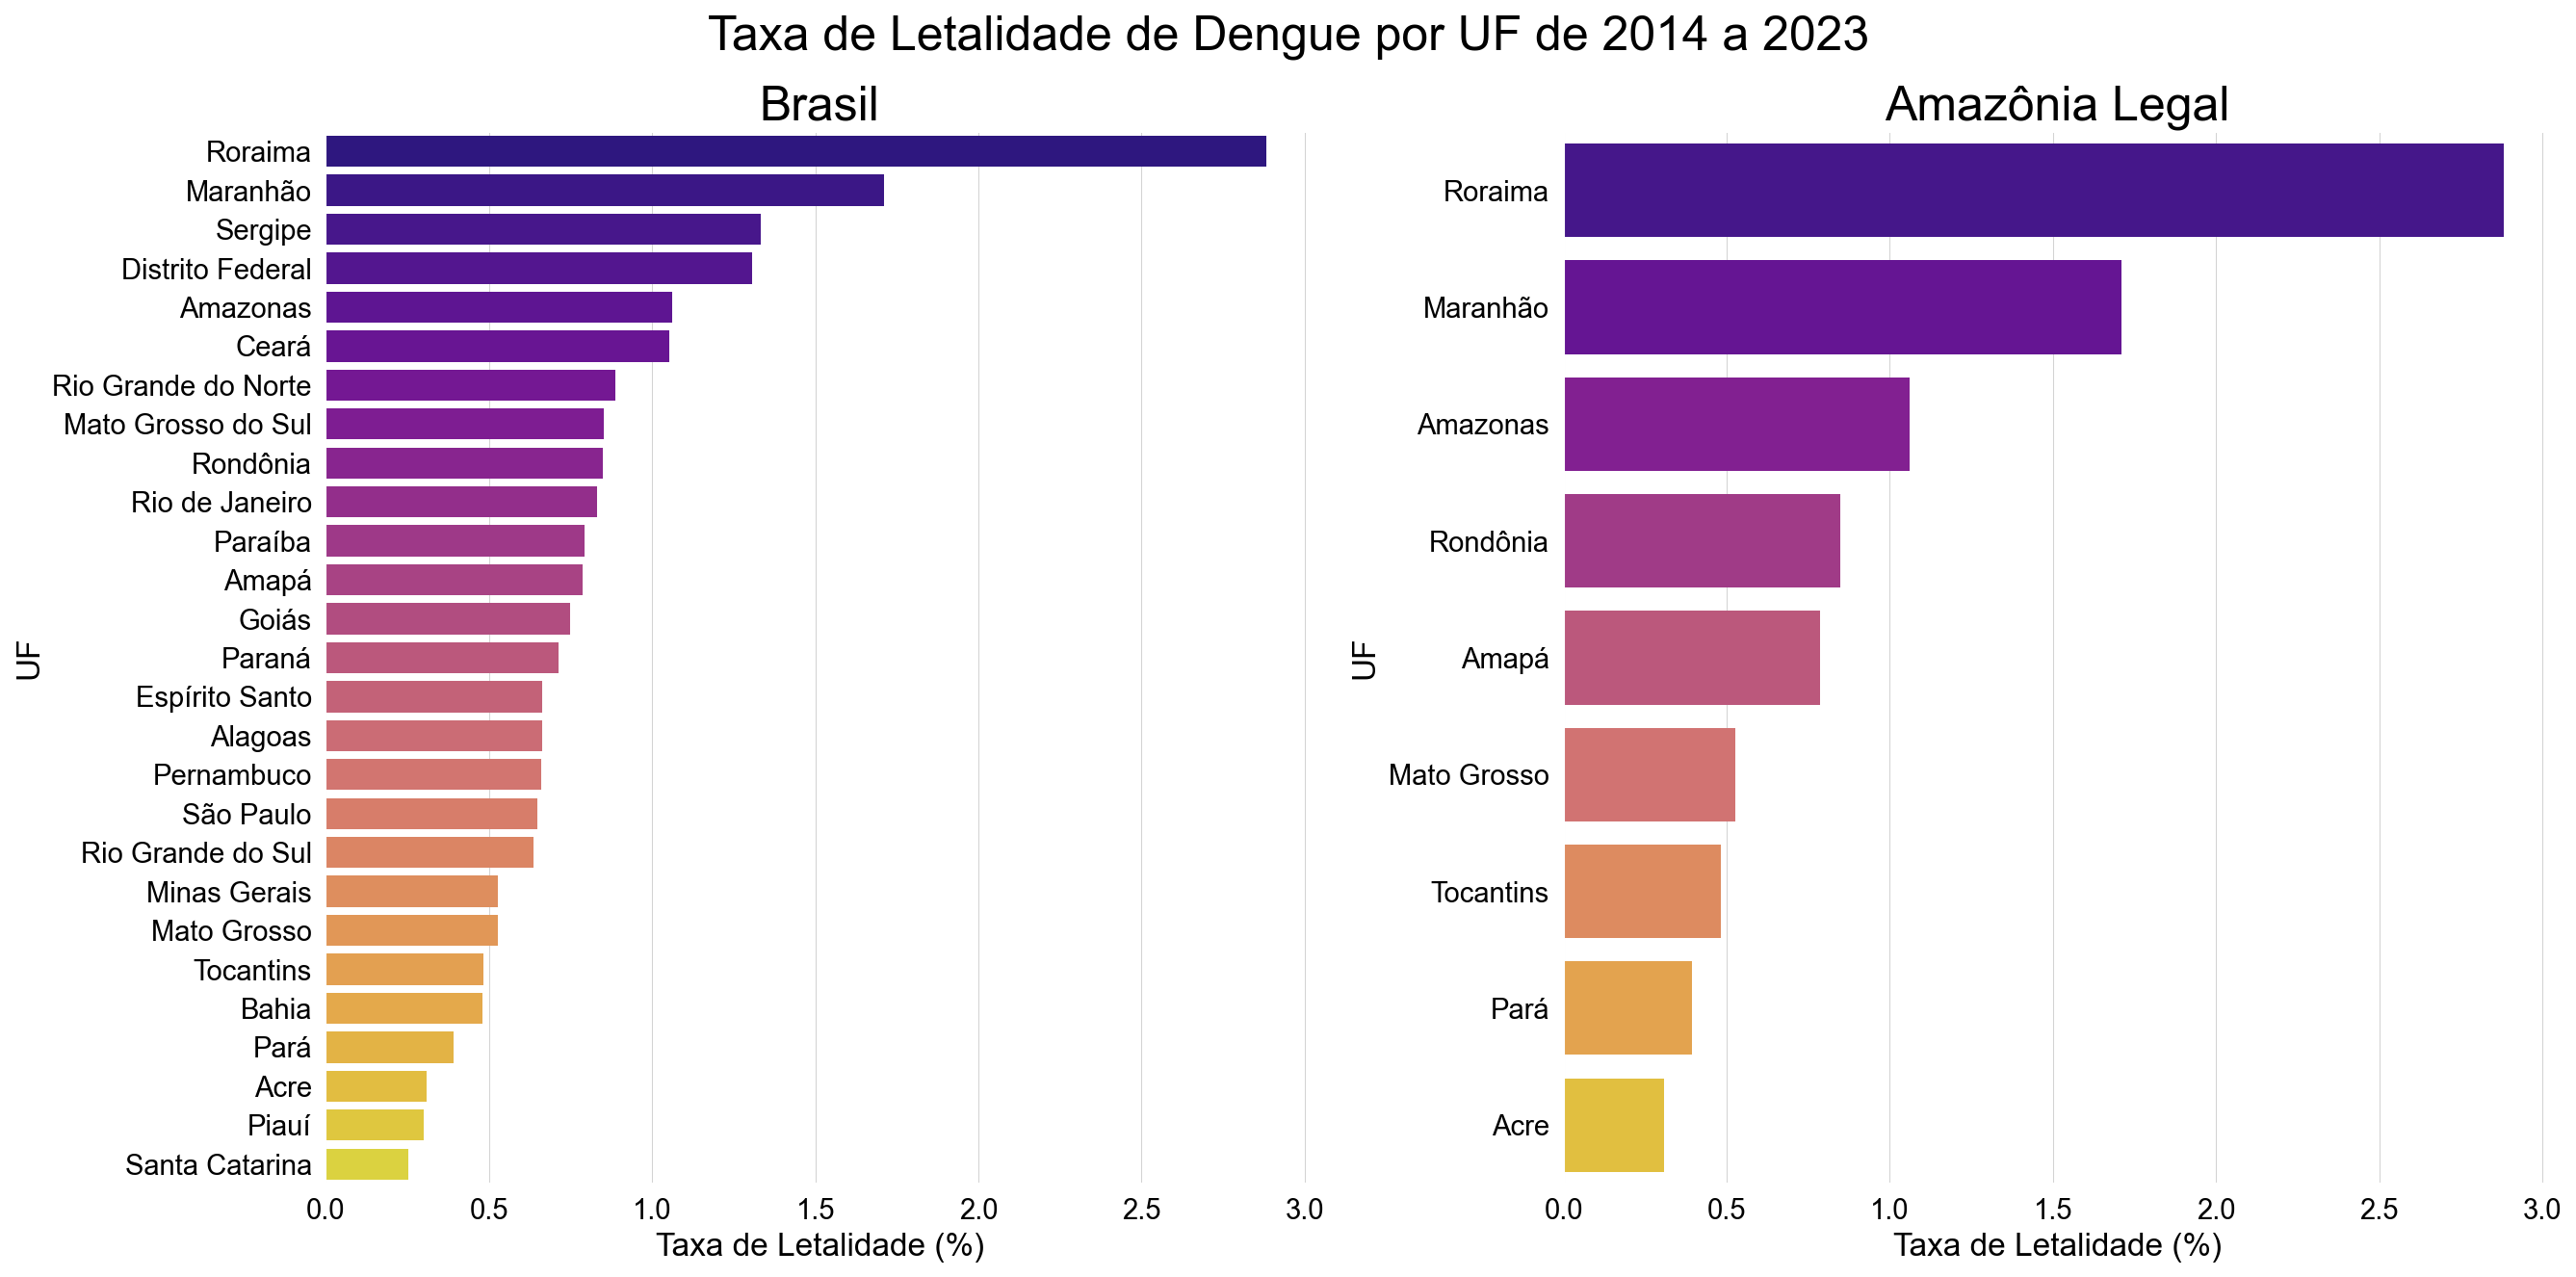

In [51]:
# Data manipulation
aux1 = df_txlet[df_txlet['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='txlet', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

# Figure
fig, axes = plt.subplots(1, 2)

ax1 = sns.barplot(data=aux1, x='txlet', y='nome_uf', palette='plasma', ax=axes[0])
ax1 = set_plot(ax1, 'Brasil', 'Taxa de Letalidade (%)', 'UF')

ax2 = sns.barplot(data=aux2, x='txlet', y='nome_uf', palette='plasma', ax=axes[1])
ax2 = set_plot(ax2, 'Amazônia Legal', 'Taxa de Letalidade (%)', 'UF')

plt.suptitle('Taxa de Letalidade de Dengue por UF de 2014 a 2023')
plt.tight_layout()

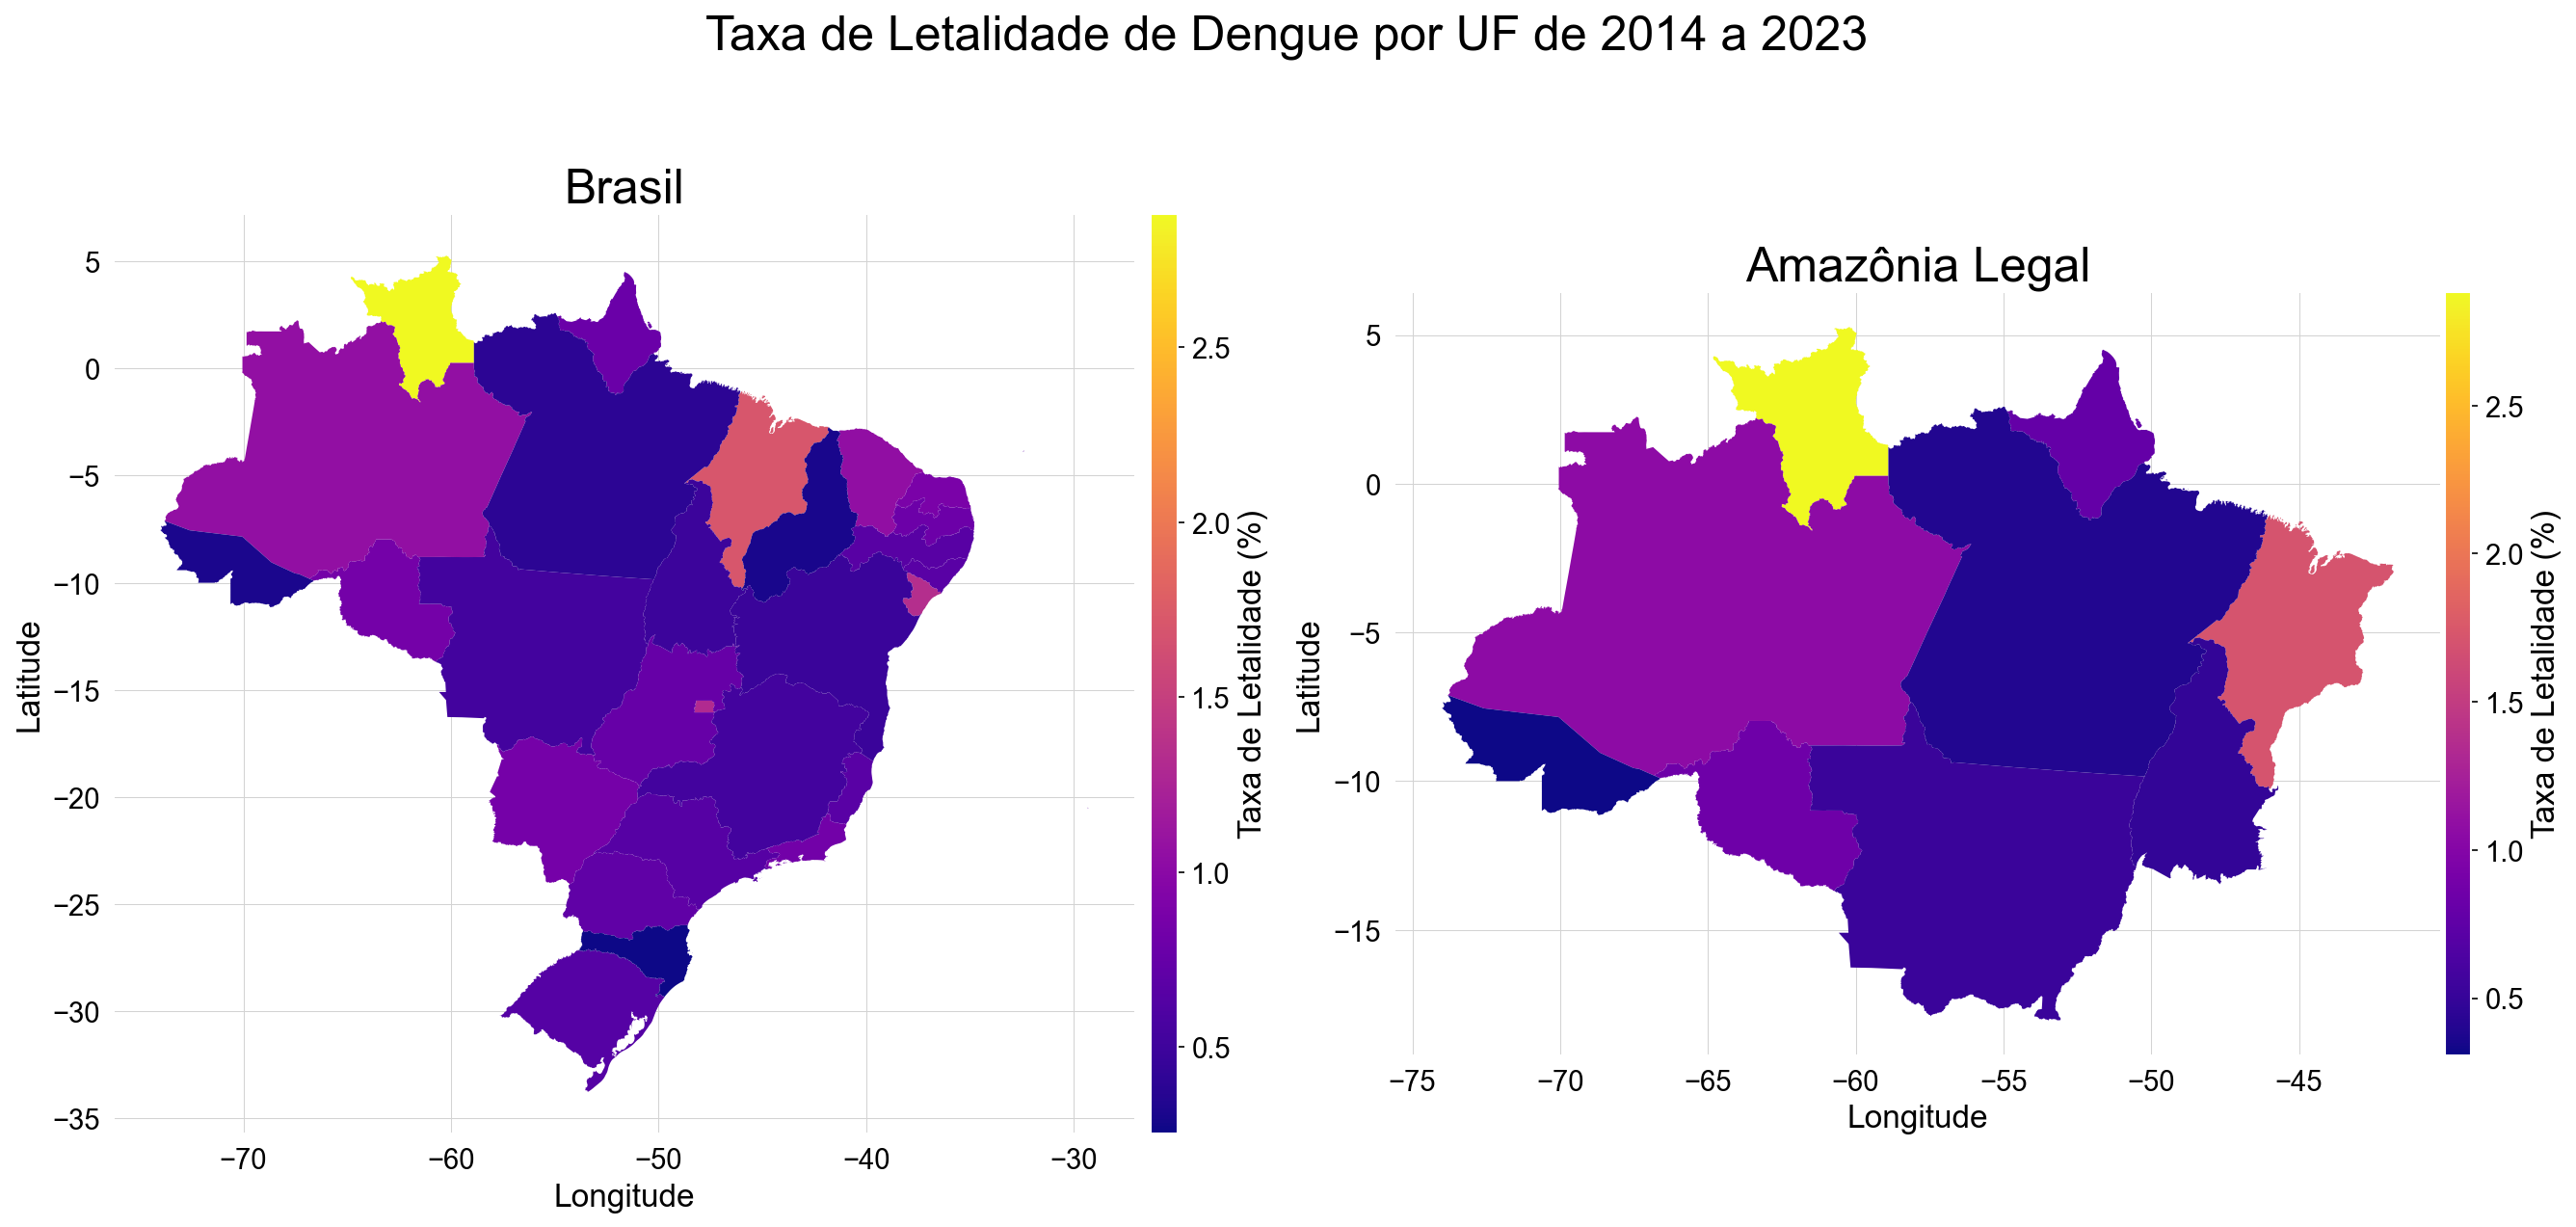

In [52]:
# Data manipulation
aux1 = df_txlet[df_txlet['ano'].isin(range(2014, 2024))].groupby(['nome_uf', 'id_uf'])\
            .sum().reset_index().sort_values(by='txlet', ascending=False)
aux2 = aux1[aux1['nome_uf'].isin(nome_alb)]

aux1 = aux1.merge(gdf, on='id_uf')
aux2 = aux2.merge(gdf, on='id_uf')

aux1 = gpd.GeoDataFrame(aux1[['nome_uf', 'id_uf', 'txlet', 'geometry']], geometry=aux1.geometry)
aux2 = gpd.GeoDataFrame(aux2[['nome_uf', 'id_uf', 'txlet', 'geometry']], geometry=aux2.geometry)

# Figure
fig, axes = plt.subplots(1, 2)

# Plot 1
ax1 = aux1.plot(ax=axes[0], column='txlet', cmap='plasma', legend=False)

# Customize 1
ax1 = set_plot(ax1, 'Brasil', 'Longitude', 'Latitude')

# Legend 1
div   = make_axes_locatable(axes[0])
cax1  = div.append_axes('right', size='2.5%', pad=0)
cbar1 = fig.colorbar(axes[0].collections[0], cax=cax1)
cbar1 = cbar1.set_label('Taxa de Letalidade (%)', color='black')

# Plot 2
ax2 = aux2.plot(ax=axes[1], column='txlet', cmap='plasma', legend=False)

# Customize 2
ax2 = set_plot(ax2, 'Amazônia Legal', 'Longitude', 'Latitude')

# Legend 2
div   = make_axes_locatable(axes[1])
cax2  = div.append_axes('right', size='2.5%', pad=0)
cbar2 = fig.colorbar(axes[1].collections[0], cax=cax2)
cbar2 = cbar2.set_label('Taxa de Letalidade (%)', color='black')

# Figure update
plt.suptitle('Taxa de Letalidade de Dengue por UF de 2014 a 2023')
plt.tight_layout()

### 3.5. Evolução da Taxa de Incidência ao longo dos períodos

### 3.6. Evolução da Taxa de Letalidade ao longo dos períodos

## 4. Data Visualization

### Avaliação da Taxa de Incidência entre estados da Amazônia Legal Brasileira (ALB)

### Comparação da Taxa de Incidência em estados da ALB e outros estados

### Avaliação da Taxa de Letalidade entre estados da ALB

### Avaliação da Taxa de Letalidade em estados da ALB e outros estados

In [ ]:
# Juntar os dados de casos de dengue com os dados geográficos dos estados
gdf_uf_casos = pd.merge(gdf_uf, df_casos[df_casos['ano'] == 2023].groupby(['id_uf']).sum().reset_index(), on=['id_uf'])

# Quantiles
quantiles = gdf_uf_casos['casos'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0])
quantile_bins = [quantiles.iloc[i] for i in range(6)]

cmap = cm.get_cmap('Oranges')

# Normalizando dados com Normalize do matplotlib
norm = Normalize(vmin=gdf_uf_casos['casos'].min(), vmax=gdf_uf_casos['casos'].max())

# Figura
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot
gdf_uf_casos.plot(column='casos', ax=ax, cmap=cmap, linewidth=0.3, edgecolor='black', scheme='quantiles', k=5)

# Barra de cores
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical')

plt.title('Casos de Dengue em 2023')
plt.xlim(-75, -30)
plt.tick_params(left=False, bottom=False)